In [1]:
from torchvision import models
import torchvision
import torch
from torch import nn
from torch.utils.data import TensorDataset,DataLoader
import torchvision.transforms as transforms
from torchtext.data.utils import get_tokenizer
import matplotlib.pyplot as plt
import numpy as np

import pickle
import gc
from tqdm import tqdm
import pandas as pd

from datasets import list_datasets
from datasets import load_dataset
import nltk
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec

import sklearn
import os
from nltk.corpus import wordnet

# nltk.download('punkt')

/home/yl535/.local/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package punkt to /home/yl535/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
def loadGloveModel(File):
    print("Loading Glove Model")
    f = open(File,'r')
    gloveModel = {}
    for line in f:
        splitLines = line.split()
        word = splitLines[0]
        wordEmbedding = np.array([float(value) for value in splitLines[1:]])
        gloveModel[word] = wordEmbedding
    print(len(gloveModel)," words loaded!")
    return gloveModel

gloveModel = loadGloveModel("/local/scratch/yl535/glove.42B.300d.txt")
glove_vocab = gloveModel.keys()


Loading Glove Model
1917494  words loaded!


In [10]:
gloveModel['word']

array([-1.3142e-01, -2.7446e-01,  2.3117e-03,  3.8385e-02, -4.4652e-01,
       -5.9866e-02, -3.3413e+00,  5.8563e-01,  4.8697e-02, -8.8974e-02,
        9.9224e-02, -1.8718e-01,  1.6412e-01, -1.9177e-01, -6.0507e-02,
       -9.8204e-03, -2.9133e-02, -1.7755e-01,  2.1721e-01,  3.2681e-01,
       -1.1203e-01, -1.1757e-01,  2.5316e-02,  2.4638e-01,  2.3976e-01,
        3.2587e-02, -1.6208e-01, -2.0086e-01,  3.3976e-01, -8.5481e-01,
       -2.1307e-01, -3.8614e-01,  1.6125e-01,  7.1117e-02, -2.7369e-01,
       -9.6669e-03,  1.7033e-01,  5.0429e-02, -3.0805e-01, -2.9375e-01,
        1.3484e-01,  4.9814e-01, -3.9112e-01,  2.0181e-02,  3.1343e-01,
       -9.3078e-03,  6.5043e-01, -1.4882e-01,  1.7239e-02, -9.7101e-02,
       -2.4606e-02, -3.0464e-01,  3.9072e-01, -1.8133e-01,  8.4682e-02,
        2.6506e-01, -1.8295e-01,  5.4148e-01, -2.4119e-01, -8.1899e-01,
        3.7655e-01, -1.3297e-01,  2.0909e-01, -2.5238e-01, -4.8371e-01,
        2.6553e-01,  2.5481e-01, -2.7843e-03, -4.6484e-01,  3.88

In [2]:
dataset = load_dataset(
   'wikitext', 'wikitext-2-v1')

Reusing dataset wikitext (/home/yl535/.cache/huggingface/datasets/wikitext/wikitext-2-v1/1.0.0/aa5e094000ec7afeb74c3be92c88313cd6f132d564c7effd961c10fd47c76f20)


In [4]:
dataset.shape

{'test': (4358, 1), 'train': (36718, 1), 'validation': (3760, 1)}

In [3]:
d_train = dataset['train']['text']
d_train_tokenized = []
for line in d_train:
    if line=='':
        continue
    line_tokenized = word_tokenize(line)
    if len(line_tokenized)<5:
        continue
    d_train_tokenized.append(line_tokenized)
    


In [5]:
len(d_train_tokenized),len(d_train)
d_train_tokenized

[['=', 'Valkyria', 'Chronicles', 'III', '='],
 ['Senjō',
  'no',
  'Valkyria',
  '3',
  ':',
  '<',
  'unk',
  '>',
  'Chronicles',
  '(',
  'Japanese',
  ':',
  '戦場のヴァルキュリア3',
  ',',
  'lit',
  '.',
  'Valkyria',
  'of',
  'the',
  'Battlefield',
  '3',
  ')',
  ',',
  'commonly',
  'referred',
  'to',
  'as',
  'Valkyria',
  'Chronicles',
  'III',
  'outside',
  'Japan',
  ',',
  'is',
  'a',
  'tactical',
  'role',
  '@',
  '-',
  '@',
  'playing',
  'video',
  'game',
  'developed',
  'by',
  'Sega',
  'and',
  'Media.Vision',
  'for',
  'the',
  'PlayStation',
  'Portable',
  '.',
  'Released',
  'in',
  'January',
  '2011',
  'in',
  'Japan',
  ',',
  'it',
  'is',
  'the',
  'third',
  'game',
  'in',
  'the',
  'Valkyria',
  'series',
  '.',
  '<',
  'unk',
  '>',
  'the',
  'same',
  'fusion',
  'of',
  'tactical',
  'and',
  'real',
  '@',
  '-',
  '@',
  'time',
  'gameplay',
  'as',
  'its',
  'predecessors',
  ',',
  'the',
  'story',
  'runs',
  'parallel',
  'to',
  'the

In [6]:
EMB_DIM=300
w2v = Word2Vec(d_train_tokenized, vector_size=EMB_DIM, window=10, min_count=5, negative=15)

## Evaluation

In [5]:
# predicate_list = np.array([])
predicate_list = []
tokenizer = get_tokenizer("basic_english")
data_size = 0
for itr in range(2):
    Y_flat = pickle.load(open("/local/scratch/yl535/data_v2_preprocessed/data_v2_pca/y_preprocessed_{}.p".format(itr), "rb"))
#     y_2 = np.array([tokenizer(w)[0] if w!='' else '/SPACE' for w in Y_flat])
#     predicate_list = np.unique(np.concatenate((predicate_list,y_2)))
    predicate_list.append(Y_flat)
    data_size += Y_flat.shape[0]
    
predicate_list, predicate_count = np.unique(np.concatenate(predicate_list),return_counts=True)
predicates_table = {w:i for i,w in enumerate(predicate_list)}
predicate_count_loopup = {w:c for w,c in zip(predicate_list,predicate_count)}
predicate_size = len(predicates_table)
predicate_size,data_size

(7795, 2393101)

### MEN

In [7]:
# path_men = '/local/scratch/yl535/MEN/MEN_dataset_lemma_form.test'

# preds1 = []
# preds2 = []
# POS = []
# scores = []
# cnt = 0
# with open(path_men) as f:
#     for line in f:
#         cnt+=1
#         word1 = line.split(' ')[0].split('-')[0]
#         word2 = line.split(' ')[1].split('-')[0]
#         if (word1 in predicate_list) and (word2 in predicate_list):
#             preds1.append(predicates_table[word1])
#             POS.append(line.split(' ')[0].split('-')[1])
#             preds2.append(predicates_table[word2])
#             scores.append(float(line.split(' ')[2]))
# cnt,len(preds1),len(preds2)

NameError: name 'predicate_list' is not defined

In [8]:
path_men = '/local/scratch/yl535/MEN/MEN_dataset_lemma_form.test'

preds1 = []
preds2 = []
POS = []
scores = []
pred_scores = []
cnt = 0
with open(path_men) as f:
    for line in f:
        cnt+=1
        word1 = line.split(' ')[0].split('-')[0]
        word2 = line.split(' ')[1].split('-')[0]
        if (word1 in w2v.wv) and (word2 in w2v.wv):
            preds1.append(word1)
#             POS.append(line.split(' ')[0].split('-')[1])
            preds2.append(word2)
            pred_scores.append(w2v.wv.similarity(word1,word2))
            scores.append(float(line.split(' ')[2]))
cnt,len(preds1),len(preds2)

(1000, 614, 614)

In [9]:
pd.DataFrame(np.stack([pred_scores, scores]).T).corr(method='spearman')

,0,1
0,1.000000,0.311575
1,0.311575,1.000000


### Simlex999


In [10]:
path_simlex = '/local/scratch/yl535/SimLex-999/SimLex-999.txt'
df = pd.read_csv(path_simlex, delimiter = "\t")

In [21]:
words1 = df['word1'].values
words2 = df['word2'].values


cnt = 0
X_eval = []
Y_eval = []
for idx in range(len(words1)):
    if (words1[idx] in w2v.wv) & (words2[idx] in w2v.wv):
        X_eval.append(w2v.wv.similarity(words1[idx],words2[idx]))
        Y_eval.append(df['SimLex999'].values[idx])
        cnt+=1     
cnt
# X_eval = np.array(X_eval)
# POS = df['POS'].values


809

In [27]:
pd.DataFrame(np.stack([X_eval, Y_eval]).T).corr(method='spearman')

,0,1
0,1.000000,0.169902
1,0.169902,1.000000


### RELPRON

In [24]:
# Load dataset and tokenize

line_num = 0
vocab = []
sentences_1 = []
sentences_2 = []
with open('/local/scratch/yl535/RELPRON/relpron.all') as f:
    for line in f:
        line_num += 1
        words = line.split(' ')
#         print(words)
        pred = words[1].split('_')[0]
        text = []
        if words[0] == 'OBJ':
            subj = words[4].split('_')[0]
            verb = words[5].split('_')[0]
            obj = words[2].split('_')[0]
        else:
            subj = words[2].split('_')[0]
            verb = words[4].split('_')[0]
            obj = words[5].split('_')[0]
        
        sentences_1.append([subj,verb,obj])
        if words[0] == 'OBJ':
            sentences_2.append([subj,verb,pred])
        else:
            sentences_2.append([pred,verb,obj])

print('number of data', len(sentences_1))

# filtering
data = []
for sen1, sen2 in zip(sentences_1,sentences_2):
    if sum([w in w2v.wv for w in sen1+sen2])!=6:
        continue
    data.append([sen1,sen2])
    
print('numer of data after filtering', len(data))

number of data 1087
numer of data after filtering 740


In [43]:
scores = []

for d in data:
    sen1, sen2 = d
    s1 = np.sum(w2v.wv[sen1],0)
    s2 = np.sum(w2v.wv[sen2],0)
    scores.append(sklearn.metrics.pairwise.cosine_similarity(s1.reshape(1,-1), s2.reshape(1,-1))[0][0])
scores

[0.9488896,
 0.957562,
 0.91263926,
 0.97871375,
 0.9226567,
 0.9760965,
 0.831895,
 0.94321793,
 0.857626,
 0.9863591,
 0.9882633,
 0.9843196,
 0.96667755,
 0.9717304,
 0.9863592,
 0.9835398,
 0.9643495,
 0.9858839,
 0.90445477,
 0.9760359,
 0.9374835,
 0.8335627,
 0.98742545,
 0.9171544,
 0.8488667,
 0.7376181,
 0.9632966,
 0.95458734,
 0.6115805,
 0.74497885,
 0.91949177,
 0.87578404,
 0.7256155,
 0.60599244,
 0.61998814,
 0.980719,
 0.92525345,
 0.93935996,
 0.9191116,
 0.97300506,
 0.98437595,
 0.99062777,
 0.9106318,
 0.94171035,
 0.96713555,
 0.9753432,
 0.8937492,
 0.9379249,
 0.94289273,
 0.79935086,
 0.94955826,
 0.7621915,
 0.83687896,
 0.798066,
 0.7114963,
 0.92366225,
 0.9761924,
 0.93982553,
 0.94975066,
 0.97915876,
 0.9449336,
 0.980897,
 0.955976,
 0.94916075,
 0.95896864,
 0.91251266,
 0.9544986,
 0.82398194,
 0.8298864,
 0.91766727,
 0.9274562,
 0.86726546,
 0.93020713,
 0.91380244,
 0.9802608,
 0.90381527,
 0.94898754,
 0.8762353,
 0.9428999,
 0.97581065,
 0.892519

## GS2011

In [30]:
path_gs11 = '/local/scratch/yl535/GS2011data.txt'

df = pd.read_csv(path_gs11, delimiter = " ")
subjs = df['subject'].values
objs = df['object'].values
verbs1 = df['verb'].values
verbs2 = df['landmark'].values
Y_eval = df['input'].values

In [53]:
cnt = 0
similarity_scores = []
y_scores = []
for s,o,v1,v2,y in zip(subjs, objs, verbs1, verbs2, Y_eval):
    if (s in w2v.wv) and (o in w2v.wv) and (v1 in w2v.wv) and(v2 in w2v.wv):
        similarity = sklearn.metrics.pairwise.cosine_similarity((w2v.wv[s]+w2v.wv[o]+w2v.wv[v1],
                                                    w2v.wv[s]+w2v.wv[o]+w2v.wv[v2]))[0][1]
        similarity_scores.append(similarity)
        y_scores.append(y)
        cnt+=1
        
len(subjs),cnt,len(y_scores),len(similarity_scores)

(2500, 2073, 2073, 2073)

In [54]:
pd.DataFrame(np.stack([y_scores, similarity_scores]).T).corr(method='spearman')

,0,1
0,1.000000,0.110468
1,0.110468,1.000000


# Glove

### GS2011

In [12]:
path_gs11 = '/local/scratch/yl535/GS2011data.txt'

df = pd.read_csv(path_gs11, delimiter = " ")
subjs = df['subject'].values
objs = df['object'].values
verbs1 = df['verb'].values
verbs2 = df['landmark'].values
Y_eval = df['input'].values

In [35]:
verbs1[:10],verbs2[:10]

(array(['provide', 'provide', 'provide', 'provide', 'provide', 'provide',
        'provide', 'provide', 'provide', 'try'], dtype=object),
 array(['supply', 'leave', 'supply', 'leave', 'supply', 'leave', 'supply',
        'supply', 'leave', 'judge'], dtype=object))

In [23]:
gloveModel[v1].reshape(1,-1).shape

(1, 300)

In [30]:
# sklearn.metrics.pairwise.cosine_similarity(gloveModel[v1].reshape(1,-1),
#                                             gloveModel[v2].reshape(1,-1))
# sklearn.metrics.pairwise.cosine_similarity((gloveModel[v1],gloveModel[v2]))[0][1]


0.49215343859882743

In [15]:
cnt = 0
similarity_scores = []
y_scores = []
for s,o,v1,v2,y in zip(subjs, objs, verbs1, verbs2, Y_eval):
    if (s in glove_vocab) and (o in glove_vocab) and (v1 in glove_vocab) and(v2 in glove_vocab):
#         similarity = sklearn.metrics.pairwise.cosine_similarity((gloveModel[s]+gloveModel[o]+gloveModel[v1],
#                                                     gloveModel[s]+gloveModel[o]+gloveModel[v2]))[0][1]
        similarity = sklearn.metrics.pairwise.cosine_similarity((gloveModel[v1],gloveModel[v2]))[0][1]
        similarity_scores.append(similarity)
        y_scores.append(y)
        cnt+=1
        
len(subjs),cnt,len(y_scores),len(similarity_scores)

(2500, 2500, 2500, 2500)

In [16]:
pd.DataFrame(np.stack([y_scores, similarity_scores]).T).corr(method='spearman')

,0,1
0,1.000000,0.201124
1,0.201124,1.000000


### Simlex-999

In [32]:
path_simlex = '/local/scratch/yl535/SimLex-999/SimLex-999.txt'
df = pd.read_csv(path_simlex, delimiter = "\t")

In [33]:
words1 = df['word1'].values
words2 = df['word2'].values


cnt = 0
X_eval = []
Y_eval = []
for idx in range(len(words1)):
    if (words1[idx] in glove_vocab) & (words2[idx] in glove_vocab):
        similarity = sklearn.metrics.pairwise.cosine_similarity((gloveModel[words1[idx]],
                                                                 gloveModel[words2[idx]]))[0][1]
        X_eval.append(similarity)
        Y_eval.append(df['SimLex999'].values[idx])
        cnt+=1     
cnt

999

In [34]:
pd.DataFrame(np.stack([X_eval, Y_eval]).T).corr(method='spearman')

,0,1
0,1.000000,0.373799
1,0.373799,1.000000


### MEN

In [37]:
path_men = '/local/scratch/yl535/MEN/MEN_dataset_lemma_form.test'

preds1 = []
preds2 = []
POS = []
scores = []
pred_scores = []
cnt = 0
with open(path_men) as f:
    for line in f:
        word1 = line.split(' ')[0].split('-')[0]
        word2 = line.split(' ')[1].split('-')[0]
        if (word1 in glove_vocab) and (word2 in glove_vocab):
            cnt+=1

            similarity = sklearn.metrics.pairwise.cosine_similarity((gloveModel[word1],
                                                                 gloveModel[word2]))[0][1]
            pred_scores.append(similarity)
            scores.append(float(line.split(' ')[2]))
cnt,

(1000,)

In [38]:
pd.DataFrame(np.stack([pred_scores, scores]).T).corr(method='spearman')

,0,1
0,1.000000,0.740192
1,0.740192,1.000000


# Kuzmenko paper


In [5]:

Visual_genome_path = '/local/scratch/yl535/visualgeno/'
relations = pd.read_json(Visual_genome_path+'relationships.json')

In [6]:
# datacut: 2000*54 or 3000*36
data_cut = 3000
records = []
skip_cnt = 0
for section in range(36):
    data_startpoint = section*data_cut
    
    X,Y = [],[]
    print('data loading')
    for i in tqdm(range(data_startpoint, data_startpoint+data_cut)):
        img_id = relations.iloc[i]['image_id']
        path_folder1 = Visual_genome_path+'VG_100K/{}.jpg'.format(img_id)
        path_folder2 = Visual_genome_path+'VG_100K_2/{}.jpg'.format(img_id)
        path = path_folder1 if os.path.isfile(path_folder1) else path_folder2
        cnt = 0
        for n, relation in enumerate(relations.iloc[i]['relationships']):
#             if (relation['predicate']==[]) or (relation['subject']['synsets']==[]) or (relation['object']['synsets']==[]):
#                 print(relation['subject']['synsets'],
#                       relation['synsets'],
#                       relation['object']['synsets'])
#                 print(relation['subject']['name'] if 'name' in relation['subject'] else relation['subject']['names'],',',
#                       relation['predicate'],',',
#                       relation['object']['name'] if 'name' in relation['object'] else relation['object']['names'])
#                 skip_cnt+=1
#                 continue

            if relation['subject']['synsets']==[]:
                subj = relation['subject']['name'] if 'name' in relation['subject'] else relation['subject']['names'][0]
                if subj=='':
                    name_subj = ['-']
                else:
                    subjs = subj.split(' ')
                    name_subj = []
                    for term in subjs:
                        if wordnet.synsets(term)!=[]:
                            name_subj.append(wordnet.synsets(term)[0].name().split('.')[0])
                        else:
                            name_subj = ['-']
                    if len(name_subj)==0:
                        name_subj = ['-']
            else:
                name_subj = [term.split('.')[0] for term in relation['subject']['synsets']]
                
            #######
            if relation['object']['synsets']==[]:
                obj = relation['object']['name'] if 'name' in relation['object'] else relation['object']['names'][0]
                if obj=='':
                    name_obj = ['-']
                else:
                    objs = obj.split(' ')
                    name_obj = []
                    for term in objs:
                        if wordnet.synsets(term)!=[]:
                            name_obj.append(wordnet.synsets(term)[0].name().split('.')[0])
                        else:
                            name_obj = ['-']
                    if len(name_obj)==0:
                        name_obj = ['-']
            else:
                name_obj = [term.split('.')[0] for term in relation['object']['synsets']]


            #######
            
            if relation['synsets']==[]:
                if relation['predicate']=='':
                    name_pred = ['-']
                else:
                    name_pred = [relation['predicate']]
            else:
                name_pred = [term.split('.')[0] for term in relation['synsets']]
                
#             if (relation['predicate']==[]):
#                 name_pred = ['-']
#             else:
#                 name_pred = [term.split('.')[0] for term in relation['synsets']]
            
#             if (relation['subject']['synsets']==[]):
#                 name_subj = ['-']
#             else:
#                 name_subj = [term.split('.')[0] for term in relation['subject']['synsets']]
                
#             if (relation['object']['synsets']==[]):
#                 name_obj = ['-']
#             else:
#                 name_obj = [term.split('.')[0] for term in relation['object']['synsets']]
                
            records.append(name_subj+name_pred+name_obj)

    

  0%|          | 0/3000 [00:00<?, ?it/s]

data loading


  5%|▌         | 155/3000 [00:00<00:01, 1509.17it/s]

data loading


  4%|▍         | 120/3000 [00:00<00:02, 1180.61it/s]

data loading


  4%|▍         | 129/3000 [00:00<00:02, 1286.71it/s]

data loading


  8%|▊         | 231/3000 [00:00<00:01, 2306.30it/s]

data loading


  8%|▊         | 254/3000 [00:00<00:01, 2538.89it/s]

data loading


  8%|▊         | 249/3000 [00:00<00:01, 2295.83it/s]

data loading


  7%|▋         | 202/3000 [00:00<00:01, 2019.27it/s]

data loading


  9%|▊         | 256/3000 [00:00<00:01, 2554.85it/s]

data loading


 17%|█▋        | 502/3000 [00:00<00:00, 2504.34it/s]

data loading


  7%|▋         | 211/3000 [00:00<00:01, 2089.66it/s]

data loading


  6%|▌         | 169/3000 [00:00<00:01, 1684.49it/s]

data loading


  8%|▊         | 237/3000 [00:00<00:01, 2366.87it/s]

data loading


  9%|▊         | 257/3000 [00:00<00:01, 2569.24it/s]

data loading


  8%|▊         | 251/3000 [00:00<00:01, 2500.55it/s]

data loading


 10%|█         | 306/3000 [00:00<00:00, 3055.48it/s]

data loading


  8%|▊         | 242/3000 [00:00<00:01, 2414.34it/s]

data loading


  9%|▉         | 272/3000 [00:00<00:01, 2688.03it/s]

data loading


  8%|▊         | 249/3000 [00:00<00:01, 2477.19it/s]

data loading


  9%|▉         | 265/3000 [00:00<00:01, 2647.91it/s]

data loading


  8%|▊         | 246/3000 [00:00<00:01, 2454.30it/s]

data loading


  8%|▊         | 255/3000 [00:00<00:01, 2544.89it/s]

data loading


  8%|▊         | 246/3000 [00:00<00:01, 2459.34it/s]

data loading


  7%|▋         | 213/3000 [00:00<00:01, 2127.77it/s]

data loading


  8%|▊         | 243/3000 [00:00<00:01, 2423.97it/s]

data loading


  7%|▋         | 223/3000 [00:00<00:01, 2224.94it/s]

data loading


 15%|█▌        | 459/3000 [00:00<00:01, 2322.90it/s]

data loading


  6%|▌         | 184/3000 [00:00<00:01, 1835.94it/s]

data loading


  5%|▍         | 136/3000 [00:00<00:02, 1335.15it/s]

data loading


 10%|▉         | 286/3000 [00:00<00:00, 2855.16it/s]

data loading


  7%|▋         | 208/3000 [00:00<00:01, 2057.35it/s]

data loading


  4%|▍         | 124/3000 [00:00<00:02, 1238.74it/s]

data loading


  6%|▌         | 181/3000 [00:00<00:01, 1803.95it/s]

data loading


  7%|▋         | 202/3000 [00:00<00:01, 2015.20it/s]

data loading


  4%|▍         | 132/3000 [00:00<00:02, 1289.07it/s]

data loading


  9%|▊         | 256/3000 [00:00<00:01, 2553.23it/s]

data loading


100%|██████████| 3000/3000 [00:01<00:00, 2236.89it/s]


In [10]:
len(records)

2314819

In [7]:
vocab = np.unique(np.concatenate(records))
vocab_lookup = {w:i for i,w in enumerate(vocab)}
len(vocab)

25406

In [7]:
records_idx = []
for row in records:
    records_idx.append([vocab_lookup[term] for term in row])
    
count_matrix = np.zeros((len(vocab),len(vocab)))
for row in records_idx:
    for term in row:
        try:
            count_matrix[row,term] +=1
        except:
            print(row,term)
cooccur_density_matrix = count_matrix/np.max(count_matrix)    

In [33]:
cooccur_density_matrix

array([[8.43310505e-02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 3.58086030e-06, 1.79043015e-06],
       [0.00000000e+00, 5.37129045e-06, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.79043015e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.14851618e-05, 0.00000000e+00, 0.00000000e+00],
       [3.58086030e-06, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 2.07689897e-04, 0.00000000e+00],
       [1.79043015e-06, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.79043015e-06]])

In [2]:
def load_MEN(filter_vocab, vocab_lookup):
    path_men = '/local/scratch/yl535/MEN/MEN_dataset_lemma_form.test'

    preds1 = []
    preds2 = []
    POS = []
    scores = []
    cnt = 0
    with open(path_men) as f:
        for line in f:
            cnt+=1
            word1 = line.split(' ')[0].split('-')[0]
            word2 = line.split(' ')[1].split('-')[0]
            if (word1 in filter_vocab) and (word2 in filter_vocab):
                preds1.append(vocab_lookup[word1])
                POS.append(line.split(' ')[0].split('-')[1])
                preds2.append(vocab_lookup[word2])
                scores.append(float(line.split(' ')[2]))
                
    print('load ',len(preds1),' word pairs from ', cnt)
    return preds1, preds2, scores, POS


In [10]:
# path_men = '/local/scratch/yl535/GS2011data.txt'

# preds1 = []
# preds2 = []
# POS = []
# scores = []
# cnt = 0
# with open(path_men) as f:
#     for line in f:
#         cnt+=1
#         print(line)
#         word1 = line.split(' ')[0].split('-')[0]
#         word2 = line.split(' ')[1].split('-')[0]
#         print(word1,word2,line.split(' ')[2])

participant verb subject object landmark input hilo

participant20 provide family home supply 4 HIGH

participant20 provide government cash leave 3 LOW

participant20 provide government cash supply 7 HIGH

participant20 provide man money leave 6 HIGH

participant20 provide man money supply 7 HIGH

participant20 provide mother baby leave 1 LOW

participant20 provide mother baby supply 6 HIGH

participant20 provide employer training supply 7 HIGH

participant20 provide family home leave 1 LOW

participant20 try court offence judge 6 HIGH

participant20 write scholar book spell 3 LOW

participant20 write writer book publish 6 HIGH

participant20 run user application operate 6 HIGH

participant20 write student name spell 7 HIGH

participant20 write child word publish 5 LOW

participant20 write child word spell 7 HIGH

participant20 write scholar book publish 7 HIGH

participant20 run people round move 4 HIGH

participant20 run user application move 1 LOW

participant20 write user word spel

In [11]:
cnt

2501

In [35]:
preds1, preds2, scores, POS = load_MEN(vocab, vocab_lookup)
pred_scores = []
for w1, w2 in zip(preds1, preds2):
    pred_scores.append(sklearn.metrics.pairwise.cosine_similarity(cooccur_density_matrix[w1].reshape(1,-1),
                                                                  cooccur_density_matrix[w2].reshape(1,-1))[0][0])
    
pd.DataFrame(np.stack([pred_scores, scores]).T).corr(method='spearman')

load  815  word pairs from  1000


,0,1
0,1.00000,0.33658
1,0.33658,1.00000


In [8]:
Y_flat = pickle.load(open("/local/scratch/yl535/data_v2/y_preprocessed_{}.p".format(0), "rb"))


In [9]:
Y_flat.shape

(120869, 3)

# Lexicon model Evaluation

In [4]:
work_path = '/local/scratch/yl535/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
[W_mu, W_cov] = pickle.load(open("world_parameters.p", "rb"))
V = pickle.load(open("Lexical_parameters.p", "rb"))

W_mu = W_mu.to(device)
W_cov = W_cov.to(device)
V = V

In [14]:
# predicate_list = np.array([])
predicate_list = []
tokenizer = get_tokenizer("basic_english")

for itr in range(2):
    Y_flat = pickle.load(open(work_path+"data_v2_preprocessed/data_v2_pca/y_preprocessed_{}.p".format(itr), "rb"))
#     y_2 = np.array([tokenizer(w)[0] if w!='' else '/SPACE' for w in Y_flat])
#     predicate_list = np.unique(np.concatenate((predicate_list,y_2)))
    predicate_list.append(Y_flat)
    
predicate_list, predicate_count = np.unique(np.concatenate(predicate_list),return_counts=True)
predicates_table = {w:i for i,w in enumerate(predicate_list)}
predicate_size = len(predicates_table)
predicate_count_lookup = {w:c for w,c in zip(predicate_list,predicate_count)}
# predicate_count_lookup

{'ABOVE': 7,
 'ABOVE THE': 19,
 'AND': 15,
 'ARE PARKED ALONGSIDE OF THE': 6,
 'AT': 9,
 'AT THE': 34,
 'ATTACHED TO': 9,
 'Are in': 5,
 'Are on': 6,
 'BEHIND': 6,
 'BEHIND A': 5,
 'BEHIND THE': 12,
 'BELOW': 7,
 'BESIDE THE': 6,
 'BY THE': 20,
 'CARRYING': 7,
 'CLADDING  OF A': 6,
 'COVERED WITH': 5,
 'CROSSING THE': 5,
 'Covers': 6,
 'ENJOYING': 10,
 'FLYING IN THE': 8,
 'FROM': 5,
 'HANGING FROM': 7,
 'HANGING FROM THE': 6,
 'HANGING ON': 17,
 'HAS': 37,
 'HAS A': 44,
 'HOLDING': 12,
 'HOLDING THE': 6,
 'HOLDS': 5,
 'Holds': 7,
 'IN': 37876,
 'IN  THE': 14,
 'IN A': 111,
 'IN FRONT': 14,
 'IN FRONT OF': 16,
 'IN THE': 254,
 'IS': 11,
 'IS HOLDING A': 5,
 'IS ON': 16,
 'IS ON A': 32,
 'IS ON THE': 7,
 'IS WEARING': 31,
 'IS WEARING A': 12,
 'Is behind': 17,
 'Is beside': 6,
 'Is by': 9,
 'Is in': 84,
 'Is inside': 6,
 'Is on': 454,
 'KEY ON': 9,
 'LAYING IN': 7,
 'LEANING AGAINST': 5,
 'MADE OF': 12,
 'NEAR A': 10,
 'NEAR THE': 8,
 'NEXT TO': 42,
 'NEXT TO THE': 5,
 'OF': 128056,
 'O

In [82]:
predicate_count_lookup['blanket'],print(predicate_count_lookup)

{'ABOVE': 7, 'ABOVE THE': 19, 'AND': 15, 'ARE PARKED ALONGSIDE OF THE': 6, 'AT': 9, 'AT THE': 34, 'ATTACHED TO': 9, 'Are in': 5, 'Are on': 6, 'BEHIND': 6, 'BEHIND A': 5, 'BEHIND THE': 12, 'BELOW': 7, 'BESIDE THE': 6, 'BY THE': 20, 'CARRYING': 7, 'CLADDING  OF A': 6, 'COVERED WITH': 5, 'CROSSING THE': 5, 'Covers': 6, 'ENJOYING': 10, 'FLYING IN THE': 8, 'FROM': 5, 'HANGING FROM': 7, 'HANGING FROM THE': 6, 'HANGING ON': 17, 'HAS': 37, 'HAS A': 44, 'HOLDING': 12, 'HOLDING THE': 6, 'HOLDS': 5, 'Holds': 7, 'IN': 37876, 'IN  THE': 14, 'IN A': 111, 'IN FRONT': 14, 'IN FRONT OF': 16, 'IN THE': 254, 'IS': 11, 'IS HOLDING A': 5, 'IS ON': 16, 'IS ON A': 32, 'IS ON THE': 7, 'IS WEARING': 31, 'IS WEARING A': 12, 'Is behind': 17, 'Is beside': 6, 'Is by': 9, 'Is in': 84, 'Is inside': 6, 'Is on': 454, 'KEY ON': 9, 'LAYING IN': 7, 'LEANING AGAINST': 5, 'MADE OF': 12, 'NEAR A': 10, 'NEAR THE': 8, 'NEXT TO': 42, 'NEXT TO THE': 5, 'OF': 128056, 'OF  A': 9, 'OF  THE': 12, 'OF A': 328, 'OF AN': 10, 'OF THE':

(3933, None)

In [41]:

# hs = [np.exp(i)/np.exp(9) for i in range(10)]
hs = [0,0.000001, 0.00001, 0.0001,0.0005,0.001, 0.01, 0.1,0.3,0.4,0.6,0.7,0.9,
      0.95,0.99,0.999,0.9999,0.99999,0.999999,0.9999999,1]
word = 'IN'

def roc_cal(word,hs,pixie_pos):
    word_idx = predicates_table[word]
    word_collect = []
    for itr in tqdm(range(2)):
        x_hidden = pickle.load(open(work_path+"data_v2_preprocessed/data_v2_pca/x_preprocessed_{}.p".format(itr), "rb"))
        Y_flat = pickle.load(open(work_path+"data_v2_preprocessed/data_v2_pca/y_preprocessed_{}.p".format(itr), "rb"))

        for x_row, y_row in zip(x_hidden,Y_flat):
            if word in y_row:
                idx = np.where(y_row==word)[0][0]
                word_collect.append(x_row[idx])

    # word_collect = torch.stack(word_collect)
    negative_example = []
    for itr in tqdm(range(2)):
        x_hidden = pickle.load(open(work_path+"data_v2_preprocessed/data_v2_pca/x_preprocessed_{}.p".format(itr), "rb"))
        Y_flat = pickle.load(open(work_path+"data_v2_preprocessed/data_v2_pca/y_preprocessed_{}.p".format(itr), "rb"))

        for x_row, y_row in zip(x_hidden,Y_flat):
            if (np.random.rand()>0.99) and (len(negative_example)< len(word_collect)) and (word not in y_row):
                negative_example.append(x_row[pixie_pos])

    coord = []
    for h in hs:
        tp,fp,fn,tn = 0,0,0,0
        # positive example
        for p in word_collect:
            if torch.sigmoid(torch.sum(p*V[word_idx]))>h:
                tp +=1
            else:
                fn += 1

        # negative example
        for p in negative_example:
            if torch.sigmoid(torch.sum(p*V[word_idx]))>h:
                fp+=1
            else:
                tn +=1

        tpr = tp/(tp+fn)
        fpr = fp/(fp+tn)
        coord.append([fpr,tpr])
    return coord

In [55]:
hs = [0,0.000001, 0.00001, 0.0001,0.0005,0.001, 0.01, 0.1,0.3,0.4,0.6,0.7,0.9,0.95,0.99,0.99999,1]

coord = roc_cal('IN',hs)

100%|██████████| 2/2 [00:09<00:00,  4.80s/it]


In [56]:
x = [row[0] for row in coord]
y = [row[1] for row in coord]

100%|██████████| 2/2 [00:09<00:00,  4.87s/it]


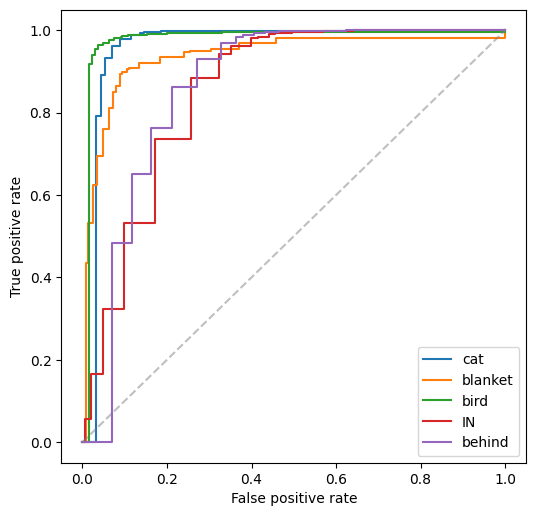

In [42]:
plt.figure(figsize=(6,6), dpi= 100, facecolor='w', edgecolor='k')

coord = roc_cal('cat',hs,0)
x = [row[0] for row in coord]
y = [row[1] for row in coord]
plt.plot(x, y, drawstyle='steps', label='steps (=steps-pre)')

coord = roc_cal('blanket',hs,0)
x = [row[0] for row in coord]
y = [row[1] for row in coord]
plt.plot(x, y, drawstyle='steps', label='steps (=steps-pre)')
#blanket 3933, small -> bad

coord = roc_cal('bird',hs,0)
x = [row[0] for row in coord]
y = [row[1] for row in coord]
plt.plot(x, y, drawstyle='steps', label='steps (=steps-pre)')

coord = roc_cal('IN',hs,1)
x = [row[0] for row in coord]
y = [row[1] for row in coord]
plt.plot(x, y, drawstyle='steps', label='steps (=steps-pre)')

coord = roc_cal('behind',hs,1)
x = [row[0] for row in coord]
y = [row[1] for row in coord]
plt.plot(x, y, drawstyle='steps', label='steps (=steps-pre)')


plt.legend(['cat','blanket','bird','IN','behind'])
# plt.ylim([0,1])
# plt.xlim([0,1])
plt.plot([0,1],[0,1],'--',alpha=0.5,color='grey')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

In [38]:
np.linspace(0.994, 1, num=50)


array([0.994     , 0.99412245, 0.9942449 , 0.99436735, 0.9944898 ,
       0.99461224, 0.99473469, 0.99485714, 0.99497959, 0.99510204,
       0.99522449, 0.99534694, 0.99546939, 0.99559184, 0.99571429,
       0.99583673, 0.99595918, 0.99608163, 0.99620408, 0.99632653,
       0.99644898, 0.99657143, 0.99669388, 0.99681633, 0.99693878,
       0.99706122, 0.99718367, 0.99730612, 0.99742857, 0.99755102,
       0.99767347, 0.99779592, 0.99791837, 0.99804082, 0.99816327,
       0.99828571, 0.99840816, 0.99853061, 0.99865306, 0.99877551,
       0.99889796, 0.99902041, 0.99914286, 0.99926531, 0.99938776,
       0.9995102 , 0.99963265, 0.9997551 , 0.99987755, 1.        ])

100%|██████████| 2/2 [00:09<00:00,  4.90s/it]


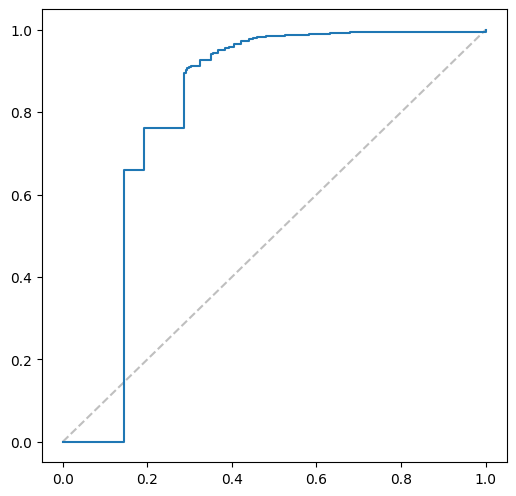

In [43]:
plt.figure(figsize=(6,6), dpi= 100, facecolor='w', edgecolor='k')
plt.plot([0,1],[0,1],'--',alpha=0.5,color='grey')

hs = [0,0.000001,0.000005, 0.00001,0.00005, 0.0001,0.0005,0.001,0.005, 0.01,
      0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,
      0.95,0.97,0.98,0.99,0.994,0.995,0.998,0.999,0.9991,0.9992,0.9993,0.9994,0.9995,0.99999,0.999999,1]
# hs = [0,0.000001,0.00001,0.0001,0.0002,0.1,1]
pixie_pos=1
coord = roc_cal('computer',hs,pixie_pos)
x = [row[0] for row in coord]
y = [row[1] for row in coord]
plt.plot(x,y, drawstyle='steps', label='steps (=steps-pre)')

In [44]:
cat_idx = predicates_table['cat']

In [ ]:
neg_energy = torch.sum(pixie*v,1)
        return torch.sigmoid(torch.sum(pixie*v,1))

In [53]:
np.random.rand()

0.06549456085882344

## RELPRON

In [5]:
work_path = '/local/scratch/yl535/'

X_eval = []
Y_eval = []
Y_map = []
line_num = 0
vocab = []
with open(work_path+'RELPRON/relpron.all') as f:
    for line in f:
        line_num += 1
        words = line.split(' ')
        print(words)
#         pred = words[1].split('_')[0]
#         text = []
#         if words[0] == 'OBJ':
#             subj = words[4].split('_')[0]
#             verb = words[5].split('_')[0]
#             obj = words[2].split('_')[0]
#         else:
#             subj = words[2].split('_')[0]
#             verb = words[4].split('_')[0]
#             obj = words[5].split('_')[0]
        
#         # filtering word not in predicate list
#         if (pred in predicate_list) and (subj in predicate_list) and (verb in predicate_list) and (obj in predicate_list):    
#             text.append(predicates_table[subj])
#             text.append(predicates_table[verb])
#             text.append(predicates_table[obj])
#             X_eval.append(text)
#             Y_eval.append([predicates_table[pred], 1 if words[0]=='OBJ' else 0])
#             Y_map.append(1 if words[0]=='OBJ' else 0)
            
#             vocab += [subj,verb,obj,pred]

vocab_size = len(vocab)
len(X_eval),len(Y_eval),line_num

['OBJ', 'garrison_N:', 'organization_N', 'that', 'army_N', 'install_V\n']
['OBJ', 'garrison_N:', 'organization_N', 'that', 'fort_N', 'house_V\n']
['OBJ', 'garrison_N:', 'organization_N', 'that', 'barracks_N', 'hold_V\n']
['OBJ', 'garrison_N:', 'organization_N', 'that', 'force_N', 'besiege_V\n']
['OBJ', 'garrison_N:', 'organization_N', 'that', 'government_N', 'station_V\n']
['SBJ', 'garrison_N:', 'organization_N', 'that', 'defend_V', 'castle_N', '\n']
['SBJ', 'garrison_N:', 'organization_N', 'that', 'hold_V', 'city_N', '\n']
['SBJ', 'garrison_N:', 'organization_N', 'that', 'occupy_V', 'outpost_N', '\n']
['SBJ', 'garrison_N:', 'organization_N', 'that', 'guard_V', 'fort_N', '\n']
['SBJ', 'garrison_N:', 'organization_N', 'that', 'withstand_V', 'siege_N', '\n']
['OBJ', 'mission_N:', 'organization_N', 'that', 'church_N', 'establish_V\n']
['OBJ', 'mission_N:', 'organization_N', 'that', 'envoy_N', 'lead_V\n']
['OBJ', 'mission_N:', 'organization_N', 'that', 'government_N', 'send_V\n']
['OBJ', '

(0, 0, 1087)

## GS2011

In [2]:
path_gs11 = '/local/scratch/yl535/GS2011data.txt'
df = pd.read_csv(path_gs11, delimiter = " ")
subjs = df['subject'].values
objs = df['object'].values
verbs1 = df['verb'].values
verbs2 = df['landmark'].values
Y_eval = df['input'].values

In [5]:
df

,participant,verb,subject,object,landmark,input,hilo
0,participant20,provide,family,home,supply,4,HIGH
1,participant20,provide,government,cash,leave,3,LOW
2,participant20,provide,government,cash,supply,7,HIGH
3,participant20,provide,man,money,leave,6,HIGH
4,participant20,provide,man,money,supply,7,HIGH
...,...,...,...,...,...,...,...
2495,participant8,say,priest,prayer,state,2,LOW
2496,participant8,say,speaker,word,allege,4,LOW
2497,participant8,say,people,prayer,state,2,LOW
2498,participant8,say,priest,prayer,allege,3,LOW
